In [3]:
import keras

In [4]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()

In [5]:
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y  

In [111]:
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import Input, Dense, BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512,256,128]):
    input_layer = Input(input_shape)
    
    for i, num_unit in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=num_unit, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=num_unit, activation='relu', name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    out = Dense(units=output_units, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [63]:
def boolMap(arr):
    if arr >= 0.5:
        return 1
    else:
        return 0

In [173]:
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
from keras.callbacks import Callback
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
class f1sc(Callback):
    def on_train_begin(self, epoch, logs={}):
        #logs参数，这个参数是一个字典，里面包好前一个批量、前一个轮次或前一次训练的信息（训练的指标和验证指标等)
        logs = logs or {}
        record_items = ['val_auc', 'val_f1sc', 'val_fp', 'val_fn', 'val_tp', 'val_tn']
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
        #params: 字典。训练参数， (例如，verbosity, batch size, number of epochs...)
    def on_epoch_end(self, epoch, logs={}):
        logs = logs or {}
        
        #self.validation_data：传入fit作为验证数据的值
        y_true = self.validation_data[1].argmax(axis=1)
        #self.validation_data[1] = y_test
        #.argmax: 返回沿轴axis最大值的索引 (https://blog.csdn.net/u013713117/article/details/53965572)
        
        #self.model：调用回调函数的模型实例
        y_pred = self.model.predict(self.validation_data[0]).argmax(axis=1)
        #self.validation_data[0] = x_test 
        # -> y_pred = model.predict(x_test) == self.model.predict(self.validation_data[0])
        
        
         
        logs['val_f1sc']=f1_score(y_true=y_true, y_pred=y_pred, average='weighted')

class Record_tp_tn(Callback):
    def on_train_begin(self, epoch, logs={}):
        logs = logs or {}
        record_items = ['val_auc', 'val_f1sc', 'val_fp', 'val_fn', 'val_tp', 'val_tn', 'val_tpr']
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    def on_epoch_end(self, epoch, logs={}):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis=1)
        y_pred = self.model.predict(self.validation_data[0]).argmax(axis=1)
        cm = confusion_matrix(y_true, y_pred)
        logs['val_tp'] = np.sum(np.diag(cm))
        logs['val_tpr'] = np.sum(np.diag(cm))/len(self.validation_data[0])
    
log_f1sc = f1sc()
rec_tptn = Record_tp_tn()

In [174]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

model.fit(x_train,y_train, epochs=EPOCHS, batch_size=BATCH_SIZE
          , validation_data=(x_test,y_test),shuffle=True,callbacks=[log_f1sc])

train_loss = model.history.history['loss']
valid_loss = model.history.history['val_loss']
train_acc = model.history.history['acc']
valid_acc = model.history.history['val_acc']

valid_f1sc = model.history.history['val_f1sc']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_58 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_59 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_60 (Batc (None, 128)               512       
__________

C:\Users\User\Anaconda3\envs\DL\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


50000/50000 [==============================] - 5s 90us/step - loss: 1.7269 - acc: 0.3914 - val_loss: 6.1120 - val_acc: 0.1163
Epoch 3/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.6246 - acc: 0.4307 - val_loss: 3.7352 - val_acc: 0.1496
Epoch 4/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.5645 - acc: 0.4530 - val_loss: 2.3267 - val_acc: 0.2643
Epoch 5/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.5189 - acc: 0.4688 - val_loss: 1.8470 - val_acc: 0.3696
Epoch 6/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.4799 - acc: 0.4839 - val_loss: 1.6455 - val_acc: 0.4193
Epoch 7/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.4481 - acc: 0.4975 - val_loss: 1.5911 - val_acc: 0.4412
Epoch 8/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.4183 - acc: 0.5072 - val_loss: 1.5303 - val_acc: 0.4570
Epoch 9/50
50000/50000 [============================

In [175]:
model2 = build_mlp(input_shape=x_train.shape[1:])
model2.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

model2.fit(x_train,y_train, epochs=EPOCHS, batch_size=BATCH_SIZE
          , validation_data=(x_test,y_test),shuffle=True,callbacks=[rec_tptn])

train_loss = model2.history.history['loss']
valid_loss = model2.history.history['val_loss']
train_acc = model2.history.history['acc']
valid_acc = model2.history.history['val_acc']

valid_tp = model2.history.history['val_tp']
valid_tpr = model2.history.history['val_tpr']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_61 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_62 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_63 (Batc (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.7929 - acc: 0.7409 - val_loss: 1.4813 - val_acc: 0.5105


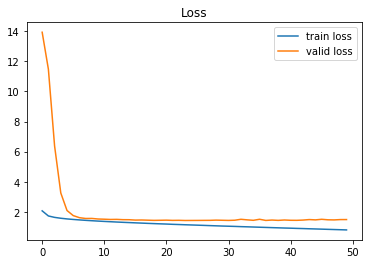

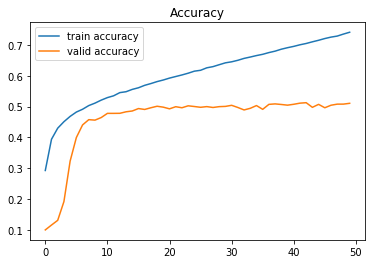

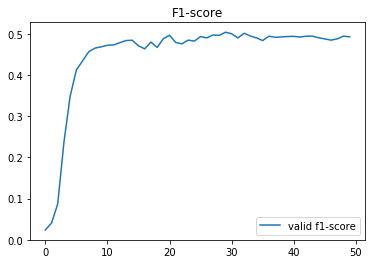

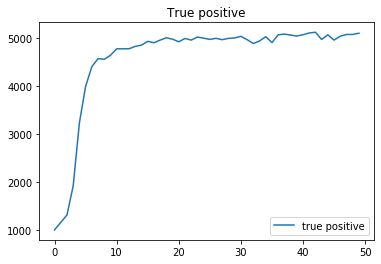

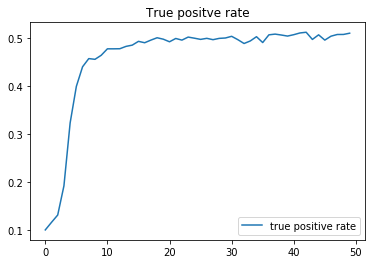

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_f1sc, label='valid f1-score')
plt.legend()
plt.title('F1-score')
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label='true positive')
plt.legend()
plt.title('True positive')
plt.show()

plt.plot(range(len(valid_tpr)), valid_tpr, label='true positive rate')
plt.legend()
plt.title('True positve rate')
plt.show()